# Modeling the Rossiter-McLaughlin effect with `starry`

In this notebook, we'll derive how to express the radial velocity field of a star at an arbitrary orientation on the sky in terms of spherical harmonics. This allows us to use `starry` to model the Rossiter-McLaughlin waveform **analytically**!

First, let's import some stuff. We'll use `sympy` for the derivations.

In [1]:
import numpy as np
from IPython.display import display, Math
import sympy
from sympy import *
from sympy.functions.special.tensor_functions import KroneckerDelta
print("Using sympy version", sympy.__version__)

# Initialize the session
init_session(quiet=True)

# Define our symbols
x, y, z, mu, nu, l, m, j, k, p, q, n, A, B, C, alpha, omeq = symbols('x y z mu nu l m j k p q n A B C alpha \omega_{eq}')

Using sympy version 1.3



## The radial velocity field of a star

The polynomial describing the radial component of the velocity field on the projected disk of a star is given by ([Short et al. 2018](https://arxiv.org/abs/1810.09565))

$f(\mathbf{x}, \mathbf{y}, \mathbf{z}) = \omega_{eq}(A\mathbf{x} + B\mathbf{y})(1 - \alpha(-B\mathbf{x} + A\mathbf{y} + C\mathbf{z})^2)$

where 

$A = \sin(i)\cos(\lambda)$

$B = \sin(i)\sin(\lambda)$

$C = \cos(i)$

and $i$ and $\lambda$ are the stellar inclination and obliquity, respectively. The constant $\alpha$ is the shear due to differential rotation. We are assuming a simple linear shear according to the following equation:

$\omega = \omega_{eq}(1 - \alpha \sin^2\theta)$,

where $\omega$ is the angular rotational velocity at a point on the surface, $\omega_{eq}$ is the velocity at the equator, and $\theta$ is the polar angle (latitude).

## Let's expand this function

If we expand all the products in $f$, we can write it as a dot product of a polynomial coefficient vector and the polynomial basis defined in Luger et al. (2018):

In [2]:
def poly_basis(n, x, y):
    """Return the n^th term in the polynomial basis."""
    l = Rational(floor(sqrt(n)))
    m = Rational(n - l * l - l)
    mu = Rational(l - m)
    nu = Rational(l + m)
    if (nu % 2 == 0):
        i = Rational(mu, 2)
        j = Rational(nu, 2)
        k = Rational(0)
    else:
        i = Rational(mu - 1, 2)
        j = Rational(nu - 1, 2)
        k = Rational(1)
    return x ** i * y ** j * sqrt(1 - x ** 2 - y ** 2) ** k

# Compute the polynomial basis
basis = Matrix([poly_basis(n, x, y) for n in range(16)]).T

Here's what the polynomial basis looks like (recall that $z = \sqrt{1 - x^2 - y^2}$):

In [3]:
basis

⎡         _______________              _______________            ____________
⎢        ╱    2    2           2      ╱    2    2                ╱    2    2  
⎣1  x  ╲╱  - x  - y  + 1   y  x   x⋅╲╱  - x  - y  + 1   x⋅y  y⋅╲╱  - x  - y  +

___                _______________               _______________              
      2   3   2   ╱    2    2        2          ╱    2    2          2   2   ╱
 1   y   x   x ⋅╲╱  - x  - y  + 1   x ⋅y  x⋅y⋅╲╱  - x  - y  + 1   x⋅y   y ⋅╲╱ 

_______________    ⎤
    2    2        3⎥
 - x  - y  + 1   y ⎦

And here's the function we wish to express:

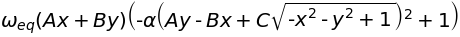

In [4]:
f = omeq * (A * x + B * y) * (1 - alpha * (-B * x + A * y + C * sqrt(1 - x ** 2 - y ** 2)) ** 2)
f

We can use `sympy` to figure out the (exact) representation of `f` in the polynomial basis:

In [5]:
def Coefficient(expression, term):
    """Return the coefficient multiplying `term` in `expression`."""
    # Get the coefficient
    coeff = expression.coeff(term)
    # Set any non-constants in this coefficient to zero. If the coefficient
    # is not a constant, this is not the term we are interested in!
    coeff = coeff.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)
    return coeff

vec = Matrix([Coefficient(expand(f), term) for term in basis])
vec

⎡                              0                               ⎤
⎢                                                              ⎥
⎢                  2                                           ⎥
⎢             - A⋅C ⋅\omega_{eq}⋅α + A⋅\omega_{eq}             ⎥
⎢                                                              ⎥
⎢                              0                               ⎥
⎢                                                              ⎥
⎢                  2                                           ⎥
⎢             - B⋅C ⋅\omega_{eq}⋅α + B⋅\omega_{eq}             ⎥
⎢                                                              ⎥
⎢                              0                               ⎥
⎢                                                              ⎥
⎢                              0                               ⎥
⎢                                                              ⎥
⎢                              0                               ⎥
⎢                        

We can check that dotting this vector with the polynomial basis yields the original function $f$:

In [6]:
simplify(factor(basis.dot(vec)) - f) == 0

True

## Now let's represent it in terms of spherical harmonics

Now that we have the vector of polynomial coefficients `vec`, we want to apply a change-of-basis transformation to figure out their (exact) representation in terms of spherical harmonics.

As in Luger et al. (2018), let's compute the change of basis matrix from polynomials to spherical harmonic coefficients. This is the inverse of the $A_1$ matrix introduced in Luger et al. (2018). Note that it includes the normalization of $\frac{2}{\sqrt{\pi}}$ used internally by `starry`.

In [7]:
def SA(l, m):
    """A spherical harmonic normalization constant."""
    return sqrt((2 - KroneckerDelta(m, 0)) * (2 * l + 1) * factorial(l - m) / (4 * pi * factorial(l + m)))

def SB(l, m, j, k):
    """Another spherical harmonic normalization constant."""
    try: 
        ratio = factorial(Rational(l + m + k - 1, 2)) / factorial(Rational(-l + m + k - 1,  2))
    except ValueError:
        ratio = 0
    res = 2 ** l * Rational(factorial(m), (factorial(j) * factorial(k) * factorial(m - j) * factorial(l - m - k))) * ratio
    return simplify(res)

def SC(p, q, k):
    """Return the binomial theorem coefficient `C`."""
    res = factorial(Rational(k, 2)) / (factorial(Rational(q, 2)) * factorial(Rational(k - p, 2)) * factorial(Rational(p - q, 2)))
    return simplify(res)

def Y(l, m, x, y):
    """Return the spherical harmonic of degree `l` and order `m`."""
    res = 0
    z = sqrt(1 - x ** 2 - y ** 2)
    if (m >= 0):
        for j in range(0, m + 1, 2):
            for k in range(0, l - m + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * SA(l, m) * SB(l, m, j, k) * SC(p, q, k) * x ** (m - j + p - q) * y ** (j + q)
            for k in range(1, l - m + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p) // 2) * SA(l, m) * SB(l, m, j, k) * SC(p, q, k - 1) * x ** (m - j + p - q) * y ** (j + q) * z          
    else:
        for j in range(1, abs(m) + 1, 2):
            for k in range(0, l - abs(m) + 1, 2):
                for p in range(0, k + 1, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * SA(l, abs(m)) * SB(l, abs(m), j, k) * SC(p, q, k) * x ** (abs(m) - j + p - q) * y ** (j + q)
            for k in range(1, l - abs(m) + 1, 2):
                for p in range(0, k, 2):
                    for q in range(0, p + 1, 2):
                        res += (-1) ** ((j + p - 1) // 2) * SA(l, abs(m)) * SB(l, abs(m), j, k) * SC(p, q, k - 1) * x ** (abs(m) - j + p - q) * y ** (j + q) * z

    return res

def p_Y(l, m, lmax):
    """Return the polynomial basis representation of the spherical harmonic `Y_{lm}`."""
    ylm = Y(l, m, x, y)
    res = [ylm.subs(sqrt(1 - x ** 2 - y ** 2), 0).subs(x, 0).subs(y, 0)]
    for n in range(1, (lmax + 1) ** 2):
        res.append(Coefficient(ylm, poly_basis(n, x, y)))
    return res

def A1(lmax, norm = 2 / sqrt(pi)):
    """Return the change of basis matrix A1. The columns of this matrix are given by `p_Y`."""
    res = zeros((lmax + 1) ** 2, (lmax + 1) ** 2)
    n = 0
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            res[n] = p_Y(l, m, lmax)
            n += 1
    return res * norm

We can now evaluate the change of basis matrix from spherical harmonic coefficients to polynomials, $A_1$ for $l_\mathrm{max} = 3$. We then take the inverse to go from polynomial coeffiecients to $Y_{lm}$ coefficients:

In [8]:
M = Matrix(A1(3)).inv()
M

⎡                       π                             π                       
⎢π   0     0     0      ─       0      0      0       ─        0       0      
⎢                       3                             3                       
⎢                                                                             
⎢               √3⋅π                                                          
⎢0   0     0    ────    0       0      0      0       0        0       0      
⎢                3                                                            
⎢                                                                             
⎢         √3⋅π                                                        √3⋅π    
⎢0   0    ────   0      0       0      0      0       0        0      ────    
⎢          3                                                           15     
⎢                                                                             
⎢   √3⋅π                                            

## The end result

We can finally compute the spherical harmonic coefficients of the function $f$:

In [9]:
ycoeffs = simplify(M * vec)
ycoeffs

⎡                      0                      ⎤
⎢                                             ⎥
⎢                   ⎛   2      2      2      ⎞⎥
⎢√3⋅π⋅B⋅\omega_{eq}⋅⎝- A ⋅α - B ⋅α - C ⋅α + 5⎠⎥
⎢─────────────────────────────────────────────⎥
⎢                      15                     ⎥
⎢                                             ⎥
⎢                      0                      ⎥
⎢                                             ⎥
⎢                   ⎛   2      2      2      ⎞⎥
⎢√3⋅π⋅A⋅\omega_{eq}⋅⎝- A ⋅α - B ⋅α - C ⋅α + 5⎠⎥
⎢─────────────────────────────────────────────⎥
⎢                      15                     ⎥
⎢                                             ⎥
⎢                      0                      ⎥
⎢                                             ⎥
⎢                      0                      ⎥
⎢                                             ⎥
⎢                      0                      ⎥
⎢                                             ⎥
⎢                      0                

Note that this is the **exact** spherical harmonic representation of the function `f`.

## Implementation in `starry`

Now that we've derived the spherical harmonic representation of the radial velocity field, let's look at how we model it with `starry`. Fortunately, `starry` implements all this math behind the scenes, so this is very easy to do!

In [12]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import starry
starry.config.lazy = False

To define a radial velocity map, simply pass the `rv=True` keyword when instantiating a `starry` `Map` object. We'll add quadratic limb darkening just for fun. Note that the spherical harmonic degree `ydeg` is implicitly set to zero, since we're not modeling any brightness structure on the surface of the star other than limb darkening.

In [14]:
map = starry.Map(udeg=2, rv=True)

Pre-computing some matrices... Done.


Next, let's set the properties that affect the projected radial velocity field. We'll set the inclination (in degrees), obliquity (also in degrees), equatorial velocity (in arbitrary units), and the differential rotation shear (unitless):

In [15]:
map.inc = 60
map.obl = 30
map.veq = 1.0
map.alpha = 0.3

Let's also set the limb darkening coefficients:

In [25]:
map[1] = 0.5
map[2] = 0.25

We can see what the map currently looks like. We can choose to either view the brightness map (using `rv=False`) or the velocity-weighted brightness map (using `rv=True`). The former is uninteresting, so let's view the latter:

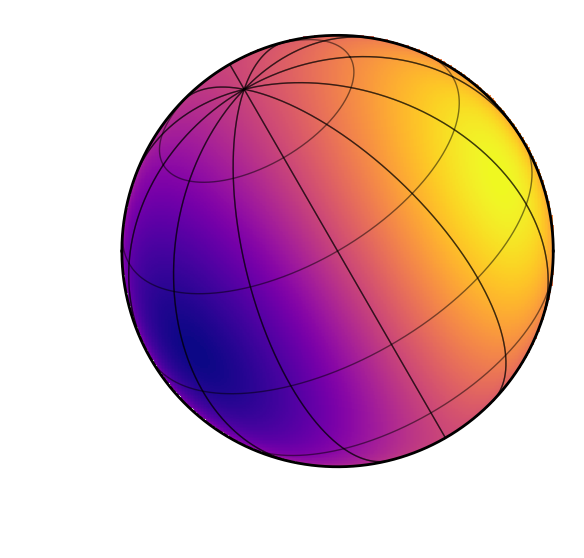

In [26]:
map.show(rv=True)

As expected, the map is inclined toward the observer and rotated on the plane of the sky. The left hemisphere is blueshifted (negative radial velocities) and the right hemisphere is redshifted (positive radial velocities). Limb darkening and differential rotation add some additional structure, causing deviations from a perfect dipolar field.

As an example, we can plot what happens when the star is transited by a planet. As usual, we can call `map.flux()` to get a light curve, but for RV maps we can also call `map.rv()` to get the radial velocity anomaly one would measure from the object:

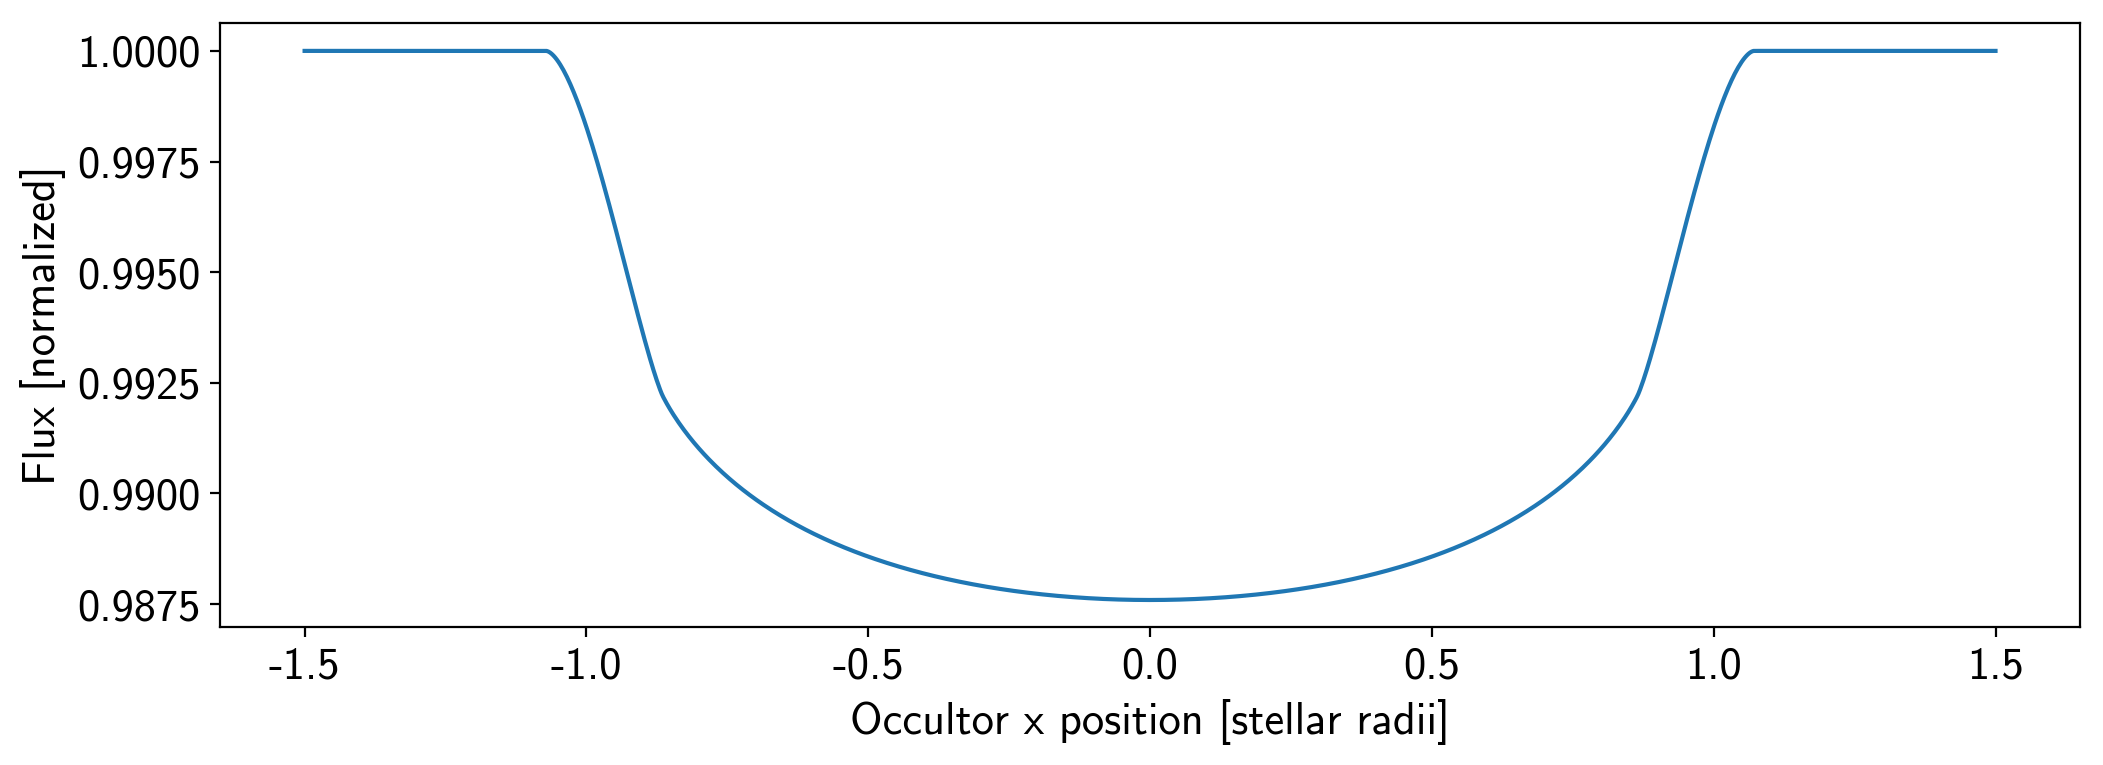

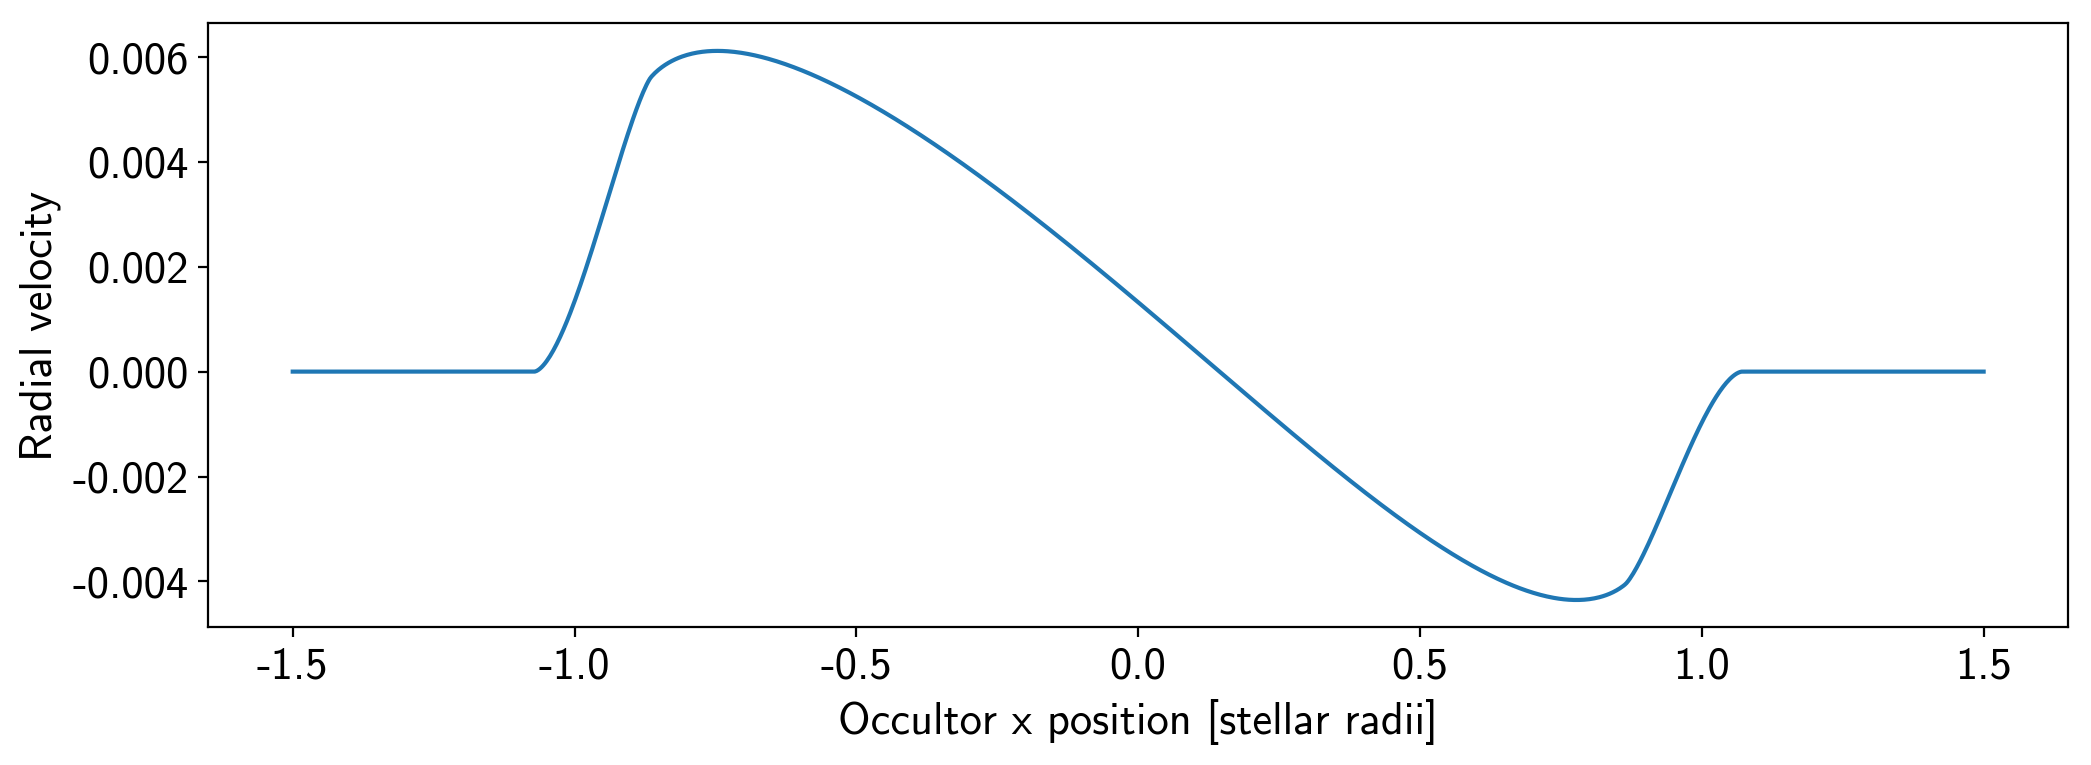

In [27]:
# Occultor properties
xo = np.linspace(-1.5, 1.5, 1000)
yo = -0.25
ro = 0.1

# Plot the flux
plt.figure()
plt.plot(xo, map.flux(xo=xo, yo=yo, ro=ro))
plt.xlabel("Occultor x position [stellar radii]")
plt.ylabel("Flux [normalized]");

# Plot the radial velocity
plt.figure()
plt.plot(xo, map.rv(xo=xo, yo=yo, ro=ro))
plt.xlabel("Occultor x position [stellar radii]")
plt.ylabel("Radial velocity");

The first plot is the usual transit light curve, and the second plot is the Rossiter-McLaughlin effect. Note that the units of the RV in the second plot are the same as the units of `map.veq`, which can be whatever you'd like!

## Interactive visualization

Below you can interactively see how different velocity profiles affect the Rossiter-McLaughlin waveform. We coded up a simple Jupyter widget to visualize the RM effect with `starry`. Try to find the parameters that best fit the measured RV data for the hot jupiter host HD 189733!

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout
import matplotlib.pyplot as plt

vslider = widgets.FloatSlider(
    value=0.1,
    min=0.1,
    max=10.0,
    step=0.01,
    description=r"$v_\mathrm{eq}$ [km / s]:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    layout=Layout(width="40%"),
)

oslider = widgets.FloatSlider(
    value=0,
    min=-90,
    max=90.0,
    step=0.1,
    description=r"$\lambda$ [deg]:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
    layout=Layout(width="40%"),
)

islider = widgets.FloatSlider(
    value=90,
    min=1,
    max=179.0,
    step=0.1,
    description=r"$i$ [deg]:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".1f",
    layout=Layout(width="40%"),
)

aslider = widgets.FloatSlider(
    value=0,
    min=0,
    max=1.0,
    step=0.01,
    description=r"$\alpha$:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    layout=Layout(width="40%"),
)

u1slider = widgets.FloatSlider(
    value=0,
    min=0.0,
    max=2.0,
    step=0.01,
    description=r"$u_1$:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    layout=Layout(width="40%"),
)

u2slider = widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description=r"$u_2$:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    layout=Layout(width="40%"),
)

yslider = widgets.FloatSlider(
    value=0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description=r"$b$:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
    layout=Layout(width="40%"),
)

rslider = widgets.FloatSlider(
    value=0.1,
    min=0.01,
    max=0.5,
    step=0.001,
    description=r"$r / R_\star$:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
    layout=Layout(width="40%"),
)


# RV data for HD 189733 from M. Bedell, corrected for the baseline
xo_189, rv_189 = np.array([
    (-1.610613874961608571e00, -9.981225587125663878e-01),
    (-1.516819480458127867e00, -9.714511071633751271e-01),
    (-1.424288949323776032e00, 6.320045379397924989e-01),
    (-1.327854659861453346e00, 5.854148371854535071e-01),
    (-1.232414426212717684e00, -1.336544425081228837e00),
    (-1.135673041276108242e00, 8.028719313260808121e-01),
    (-1.039663090115350963e00, -7.792463171881536255e-01),
    (-9.455579835532572641e-01, 1.453737600349995773e00),
    (-8.467048139722169742e-01, 4.792210501625959296e00),
    (-7.477458584637551864e-01, 1.599068367822837899e01),
    (-6.553772659628724906e-01, 2.568976397998631001e01),
    (-5.591570578315693263e-01, 3.354680499304413388e01),
    (-4.625798890680289377e-01, 3.502869252636628516e01),
    (-3.650748292997558764e-01, 3.120010282560906489e01),
    (-2.704380165973445105e-01, 2.425808674314976088e01),
    (-1.722747673202078555e-01, 1.747718457640439738e01),
    (-7.671271240261887114e-02, 7.868697041703853756e00),
    (1.885820039767528364e-02, -1.486790492997897672e00),
    (1.155924921815155992e-01, -1.257290268435099279e01),
    (2.120216221213046814e-01, -2.145286194661639456e01),
    (3.092993853335966881e-01, -2.891529266112229379e01),
    (4.068310542953758047e-01, -3.485288236187807343e01),
    (5.022774536703960013e-01, -3.813336989657727827e01),
    (5.965030311267133234e-01, -3.469222671746319975e01),
    (6.955993594669751534e-01, -2.537275959802173020e01),
    (7.890948706217063569e-01, -1.200930395291834429e01),
    (8.859815670714117353e-01, -4.065734667423384963e00),
    (9.792870073717533375e-01, -1.655279022319518845e00),
    (1.078846540640843621e00, -2.328277573282321100e00),
    (1.172781349728483358e00, -1.592293655745379510e00),
    (1.266294524861562687e00, -8.531562584666971816e-01),
    (1.367439231357534979e00, -7.712511936460941797e-01),
    (1.658284285150540383e00, -1.439270159869920462e00),
    (1.761221193029112841e00, -1.678779727093569818e00),
    (1.853084956802548033e00, -2.067330139152545598e00),
    (1.948154374912242304e00, -1.369754796494817128e00),
    (2.037885209964362065e00, 1.118637971248972462e00),
    (2.137297896820141041e00, -5.354630210913455812e-01),
    (2.226274259361801011e00, 1.665095065392961260e00),
    (2.322326451882745779e00, 1.192561909507276141e00),
]).T

# Create the global starry maps
map = starry.Map(ydeg=0, udeg=2, rv=True)

# Force compile some functions
map.rv()
map.render()

def visualize_func(veq=1, inc=90, obl=0, alpha=0, u1=0, u2=0, yo=0, ro=0.1):
    """Interactive visualization of the RM effect."""
    # Map resolution for plotting
    res = 300

    # Set the map coefficients
    map[1] = u1
    map[2] = u2
    map.inc = inc
    map.obl = obl
    map.alpha = alpha
    map.veq = veq * 1e3

    # Check if LD is physical
    if (u1 + u2) > 1 or (u1 + 2 * u2) < 0 or u1 < 0:
        u1slider.style.handle_color = "#FF0000"
        u2slider.style.handle_color = "#FF0000"
    else:
        u1slider.style.handle_color = "#FFFFFF"
        u2slider.style.handle_color = "#FFFFFF"

    # Plot the brightness-weighted velocity field
    img = map.render(rv=True, res=res) * (np.pi / 1.0e3)
    fig = plt.figure(figsize=(15, 8))
    axim = plt.axes((0, 0.05, 0.3, 0.8))
    axcb = plt.axes((0, 0.85, 0.3, 0.03))
    axrm = plt.axes((0.4, 0.20, 0.6, 0.5))
    im = axim.imshow(
        img, cmap="RdBu_r", origin="lower", vmin=-veq, vmax=veq, extent=(-1, 1, -1, 1)
    )
    cb = plt.colorbar(im, orientation="horizontal", cax=axcb)
    cb.ax.set_xlabel("Radial velocity [km / s]")
    axim.contour(
        img,
        origin="lower",
        levels=np.linspace(-veq, veq, 20),
        colors=["k" for i in range(20)],
        alpha=0.25,
        extent=(-1, 1, -1, 1),
    )
    axim.axis("off")
    axim.set_aspect(1)
    axim.axhline(yo, color="k", alpha=0.5)
    axim.axhline(yo + 0.5 * ro, color="k", ls="--", alpha=0.5)
    axim.axhline(yo - 0.5 * ro, color="k", ls="--", alpha=0.5)

    # Compute the RM effect amplitude
    xo = np.linspace(-1 - 2 * ro, 1 + 2 * ro, 1000)
    RM = map.rv(xo=xo, yo=yo, ro=ro)

    # Plot it
    axrm.plot(xo, RM)
    axrm.set_xlabel(r"Occultor x position [$R_\star$]", fontsize=16)
    axrm.set_ylabel("Radial velocity [m /s]", fontsize=16)
    axrm.set_title("The Rossiter-McLaughlin effect", fontsize=20)
    axrm.plot(xo_189, rv_189, ".")


def visualize():
    return interact(
        visualize_func,
        veq=vslider,
        inc=islider,
        obl=oslider,
        alpha=aslider,
        u1=u1slider,
        u2=u2slider,
        yo=yslider,
        ro=rslider,
    )

visualize();

Pre-computing some matrices... Done.
Compiling `rv`... Done.
Compiling `compute_rv_filter`... Done.
Compiling `render`... Done.


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='$v_\\mathrm{eq}$ [km / s]:'…

## One possible solution

The following values should get you a pretty good fit. They are close to the means of the posterior distributions when we do a full MCMC fit of the dataset, but they are probably not the "true" values.

$v_{eq}$: 5.00

$\lambda$: -0.50

$i$: 80.0

$\alpha$: 0.65

$u_1$: 1.50

$u_2$: -0.54

$b$: -0.66

$r/R_\star$: 0.158